# Final Project: Has Polling Accuracy Changed Due to Smart Phone Usage
In the U.S., public opinion polling has been used as a tool to predict elections and understand the feelings of the american people. This data is critical in American society for political, economic, and social reasons. Polling allows politicians to calibrate their messaging in order to better serve their constituents, businesses and financial analysts use it to make assumptions on the state of the world in order to inform decisions, and voters throughout the country use it to inform how their communities are responding to political change. Since the proliferation of home telephones, polls have been conducted through calling phones and asking respondants their opinion on certain topics. The introduction of the smart phone has increased the ability of users to screen unwanted phone calls potentially skewing who is answering polling calls. This leaves us with our H1 hypothesis that the introduction of the smart phone has decreased the reliability of polling.

This project will attempt to validate or invalidate that hypothesis through measuring the spread between poll results and reality.

## Defining the research statement
H1: The introduction of the smart phone has decreased the reliability of polling

Scope: As U.S. presidential elections are the most information dense and poll covered election in the world, we will scope our project to understand how the introduction of the smart phone has effected this particular poll and election result.

Poll Providers: As there are several different poll providers, many of which change political alignment overtime, we will keep our research to Gallop polls which are generally considered the gold standard for american opinion polling. Gallup also has the added advantage of having consistently conducted polls over the time frame of our research.

Time Frame: 1980 - 2024
    By the 1980's Landline telephones completely saturated the U.S. market with smartphones and cellphones beginning to proliferate in the 1990's to 2000's, becoming ubiquitous by the mid 2015s.

Measurement: Spread between poll results and reality compared to proliferation of smartphones.
    Poll Results: As opinion changes overtime, we will assess poll results as the last poll before election
    Reality: Actual posted outcome of election
    Proliferation of smarphones: % of american households with a smartphone
    

## Required Data:

### Polling & Election Data:
Polling and Election data from Gallop is available via wikipedia, which we can pull into tables via pandas "read_html" functionality
Source: https://en.wikipedia.org/wiki/Polling_for_United_States_presidential_elections#1984_United_States_presidential_election

### Smartphone Data: 
The Pew Research center has some data that will cover most of our timeperiod, but does not cover the 2008 election period, for which we will use a comscore research report to fill. I have pulled this data into a .csv file for use in this project as it was only included on a .png.
Source: https://www.pewresearch.org/internet/fact-sheet/mobile/
Source: https://www.comscore.com/Insights/Blog/US-Smartphone-Penetration-Surpassed-80-Percent-in-2016


## Extracting and Organizing Data:

### Extracting

In [6]:
import pandas as pd

# Source URL of Wikipedia page to scrape tables from
url = "https://en.wikipedia.org/wiki/Polling_for_United_States_presidential_elections"

# Initialize dictionary to hold tables from wikipedia page
tables = {}

# Function to pull tables from wikipedia page
def get_tables(url):
    try:
        # Pandas read_html function to scrape tables from website
        Scraped_tables = pd.read_html(url)
        return Scraped_tables
    except Exception as e:
        print("Error scraping tables from wikipedia")

# Pull tables from wikipedia
tables = get_tables(url)

# Last Dictionary item not needed in dataset
Removed_Last_Item = tables.pop()

# Print the number of tables pulled from page
print(f"Found {len(tables)} tables from {url}")

# Test: Accessing tables from the Wikipedia page
for idx, table in enumerate(tables):
    print(f"\nElection {1936+idx*4}:")
    print(table.head())  # Displaying the first few rows of the table


Found 23 tables from https://en.wikipedia.org/wiki/Polling_for_United_States_presidential_elections

Election 1936:
       Month Franklin D. Roosevelt (D) % Alf Landon (R) %
0       July                         49%              45%
1     August                         49%              45%
2     August                         49%              45%
3     August                         49%              44%
4  September                         49%              45%

Election 1940:
       Month Franklin D. Roosevelt (D) % Wendell Willkie (R)%
0       July                         48%                  42%
1       July                         44%                  43%
2     August                         45%                  43%
3     August                         46%                  44%
4  September                         49%                  40%

Election 1944:
   Month Franklin D. Roosevelt (D) % Thomas E. Dewey (R) %
0  March                         55%                   41%
1  March      

### Organizing:
Now that I have all relevant data, I need to organize it into a data frame in the following form in order to run a regression and visualize data:

data_format = {
    'Election': [year, year, year, year,
    'Election Poll Spread': [+x%, -y%, +z%, -a%, +b%],
    'Smartphone Adoption': [15%, 25%, 35%, 45%, 55%]
}

In [7]:
# Initialzie clean data set
cleaned_data_set = []

# Create variable w/ file
smartphone_data_file = "/Users/colinbarsella/Documents/MPCS_Python_Programming/Final-Project-Repo/Smartphone_adoption.csv"

# Read in file into a dataframe
smartphone_df = pd.read_csv(smartphone_data_file)

# For each election pull in polling data, election results, and smartphone usage 
for idx, table in enumerate(tables):
    election_year = 1936+idx*4
    if election_year >= 1980:
        # Needed data point is 2nd to last item in the the last row of table
        election_poll_spread_str = table.iloc[-1].values[1]
        election_poll_spread = abs(float(election_poll_spread_str.replace('%', '').replace('+', '').strip()) / 100)

        # Pull in smartphone adoption rate for election year
        adoption_rate_str = smartphone_df[smartphone_df["Date"] == election_year]["Smartphone Adoption"].values[0]
        adoption_rate = float(adoption_rate_str.replace('%', '').strip()) / 100
        
        cleaned_data_set.append([election_year, election_poll_spread, adoption_rate])
    else: continue

# Create data frame with necessary data
analysis_df = pd.DataFrame(cleaned_data_set, columns=["Election Year", "Election-Poll Spread from Winner", "Smartphone Adoption Rate"])

# Print table to ensure 
print(analysis_df.head)

<bound method NDFrame.head of     Election Year  Election-Poll Spread from Winner  Smartphone Adoption Rate
0            1980                            0.0375                      0.00
1            1984                            0.0023                      0.00
2            1988                            0.0263                      0.00
3            1992                            0.0599                      0.00
4            1996                            0.0277                      0.00
5            2000                            0.0013                      0.00
6            2004                            0.0173                      0.00
7            2008                            0.0014                      0.08
8            2012                            0.0201                      0.39
9            2016                            0.0409                      0.72
10           2020                            0.0031                      0.82
11           2024                 

## Analyzing Data

In [8]:
import numpy as np
from scipy import stats


# Set indepedent (x) and depedent (y) variables
x = analysis_df["Smartphone Adoption Rate"]
y = analysis_df["Election-Poll Spread from Winner"]

# Define global assumptions
alpha = .05
n = len(x)
p = 1
h1 = "The introduction of the smart phone has decreased the reliability of polling"

# Calculate coeffecients via least squares
x_mean = x.mean()
y_mean = y.mean()

slope = np.sum((x - x_mean) * (y-y_mean)) / np.sum((x - x_mean)**2)
y_intercept = y_mean - slope * x_mean

# Calculate predicted y values given x
y_pred = y_intercept + (slope * x)

# Calculate error per prediction
errors = y - y_pred

# Calculate standard error of regression
squared_errors = errors**2
std_error = np.sqrt(np.sum(squared_errors) / (n - p - 1))

# Calculate t-, p- values 
t_stat = slope / (std_error / np.sqrt(np.sum((x - x_mean)**2)))
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df = n - p - 1))

# Run logical test to accept or reject the H1 hypothesis
print(f"Through looking at the polling spreads of the past {n} elections compared to the proliferation of smartphone usage we have ran a p-test with a confidence level of .05. The output of the model was p-value = {round(p_value,4)}")
if p_value < alpha:
    print(f"As the p_value is greater than our confidence level, we accept the H1 hypothesis that smartphone use has decreased the accuracy of polling")
else:
    print(f"As the p_value is greater than our confidence level, we reject the H1 hypothesis that smartphone use has decreased the accuracy of polling")


Through looking at the polling spreads of the past 12 elections compared to the proliferation of smartphone usage we have ran a p-test with a confidence level of .05. The output of the model was p-value = 0.5932
As the p_value is greater than our confidence level, we reject the H1 hypothesis that smartphone use has decreased the accuracy of polling


## Visualizing Data

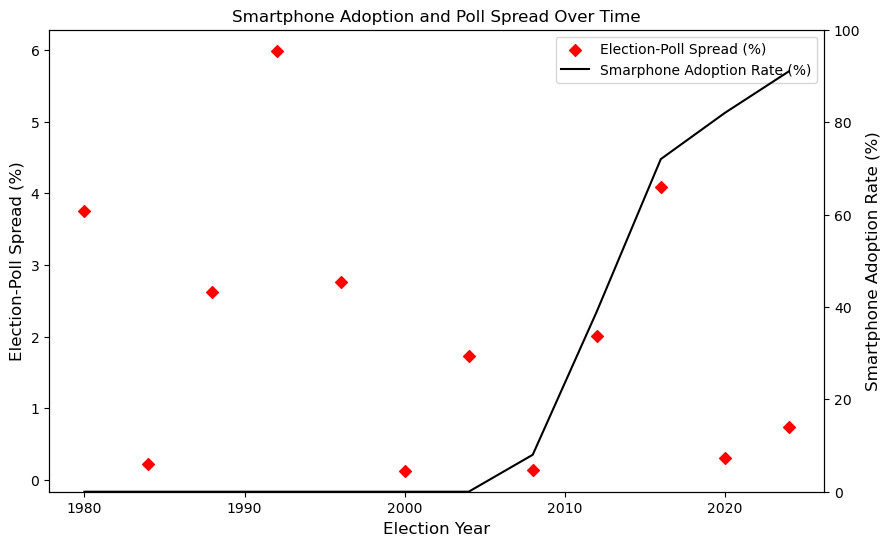

In [9]:
import matplotlib.pyplot as plt

# Create and title figure to begin plotting
fig, ax1 = plt.subplots(figsize=(10,6))
plt.title("Smartphone Adoption Rate and Election-Poll Spread", fontsize=16)

# Plot Election-Poll Spread scatter plot
ax1.scatter(analysis_df["Election Year"], analysis_df["Election-Poll Spread from Winner"] * 100, color="Red", marker="D", label="Election-Poll Spread (%)")

# Set lables and title for left y-axis for Election-Poll Spread
ax1.set_xlabel("Election Year", fontsize=12)
ax1.set_ylabel("Election-Poll Spread (%)", color="black", fontsize=12)

# Plot second y-axis for Smartphone Adoption Rate
ax2 = ax1.twinx()
ax2.plot(analysis_df["Election Year"], analysis_df["Smartphone Adoption Rate"] * 100, color="black", label="Smarphone Adoption Rate (%)")

# Set lables and title for right y-axis for Smarphone Adoption Rate (%)
ax2.set_ylabel("Smartphone Adoption Rate (%)", fontsize=12)
ax2.set_ylim(0,100)

# Set legend for chart
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
ax1.set_title("Smartphone Adoption and Poll Spread Over Time")

plt.show()

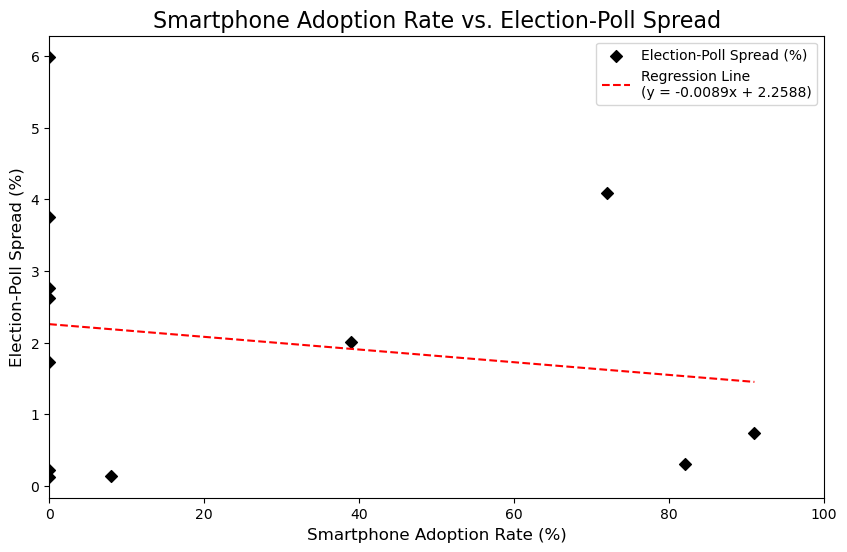

In [10]:
import numpy as np

# Create and title figure to begin plotting
fig2, ax1 = plt.subplots(figsize=(10,6))
plt.title("Smartphone Adoption Rate vs. Election-Poll Spread", fontsize=16)

# Plot Election-Poll Spread scatter plot
ax1.scatter(analysis_df["Smartphone Adoption Rate"] * 100, analysis_df["Election-Poll Spread from Winner"] * 100, color="black", marker="D", label="Election-Poll Spread (%)")

# Add regression line
x = analysis_df["Smartphone Adoption Rate"] * 100
y = analysis_df["Election-Poll Spread from Winner"] * 100

# Use numpy's polyfit to calculate regression line
coefficients = np.polyfit(x, y, 1)
regression_line = np.poly1d(coefficients)

# Plot regression line
x_line = np.linspace(x.min(), x.max(), 100)
ax1.plot(x_line, regression_line(x_line), color="red", linestyle="--", 
            label=f"Regression Line\n(y = {coefficients[0]:.4f}x + {coefficients[1]:.4f})")

# Set lables, title, and legend for left y-axis for Election-Poll Spread
ax1.set_xlabel("Smartphone Adoption Rate (%)", fontsize=12)
ax1.set_ylabel("Election-Poll Spread (%)", color="black", fontsize=12)
ax1.set_xlim(0,100)
ax1.legend(loc="best")

plt.show()

## Conclusion & Alternate Hypotheses
**Conclusion:** We reject our H1 hypothesis that smartphone adoption rate has had an impact on election-polling prediction power for Gallup. We do not see a statistically significant relationship between the adoption rate and election-polling accuracy at Gallup.

**Alternate Hypothesis:** Polling companies, in this case Gallop, are able to respond to technological change and make the correct polling adjustments. However, in years where there is technological or social change, polling results may be less accurate. We gain this alternate hypothesis from observing that in years with high increases in smartphone adoption rate 2012 & 2016, the spread between polls and election results seems to increase. 